In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import holidays  
import numpy as np


In [2]:
df = pd.read_csv(r'C:\Users\mathe\Desktop\EPSI\MSPR\DATA\datas\eco2mix-national-tr.csv', sep=';', parse_dates=['Date'], dayfirst=True)


In [3]:

cols_to_clean = ["Stockage batterie (MW)", "Déstockage batterie (MW)", "Eolien terrestre (MW)", "Eolien offshore (MW)", 
                 "Ech. comm. Angleterre (MW)", "Ech. comm. Espagne (MW)", "Ech. comm. Italie (MW)", 
                 "Ech. comm. Suisse (MW)", "Ech. comm. Allemagne-Belgique (MW)"]
for col in cols_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].replace('ND', pd.NA), errors='coerce').fillna(0)

df.interpolate(method='linear', inplace=True)


C:\Users\mathe\AppData\Local\Temp\ipykernel_26452\1642827901.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [4]:
df.columns

Index(['Périmètre', 'Nature', 'Date', 'Heure', 'Date - Heure',
       'Consommation (MW)', 'Prévision J-1 (MW)', 'Prévision J (MW)',
       'Fioul (MW)', 'Charbon (MW)', 'Gaz (MW)', 'Nucléaire (MW)',
       'Eolien (MW)', 'Eolien terrestre (MW)', 'Eolien offshore (MW)',
       'Solaire (MW)', 'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)',
       'Ech. physiques (MW)', 'Taux de CO2 (g/kWh)',
       'Ech. comm. Angleterre (MW)', 'Ech. comm. Espagne (MW)',
       'Ech. comm. Italie (MW)', 'Ech. comm. Suisse (MW)',
       'Ech. comm. Allemagne-Belgique (MW)', 'Fioul - TAC (MW)',
       'Fioul - Cogénération (MW)', 'Fioul - Autres (MW)', 'Gaz - TAC (MW)',
       'Gaz - Cogénération (MW)', 'Gaz - CCG (MW)', 'Gaz - Autres (MW)',
       'Hydraulique - Fil de l'eau + éclusée (MW)', 'Hydraulique - Lacs (MW)',
       'Hydraulique - STEP turbinage (MW)', 'Bioénergies - Déchets (MW)',
       'Bioénergies - Biomasse (MW)', 'Bioénergies - Biogaz (MW)',
       'Stockage batterie (MW)', 'Désto

In [5]:

if 'Heure' in df.columns:
    df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Heure'])


In [6]:

df['Conso_quart_heure_MWh'] = df['Consommation (MW)'] * 0.25
daily_consumption = df.groupby('Date')['Conso_quart_heure_MWh'].sum().reset_index()
daily_consumption.rename(columns={'Conso_quart_heure_MWh': 'Consommation journalière (MWh)'}, inplace=True)


In [7]:

prod_cols = ['Fioul (MW)', 'Charbon (MW)', 'Gaz (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Bioénergies (MW)', "Eolien offshore (MW)", "Eolien terrestre (MW)", 'Ech. comm. Angleterre (MW)', 'Ech. comm. Espagne (MW)', 'Ech. comm. Italie (MW)', 'Ech. comm. Suisse (MW)', 'Ech. comm. Allemagne-Belgique (MW)']
daily_prod = df.groupby('Date')[prod_cols].mean().reset_index()


In [8]:

daily_data = pd.merge(daily_consumption, daily_prod, on='Date')


In [9]:
# S'assurer que la colonne 'Date' est bien de type datetime
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

daily_data['year'] = daily_data['Date'].dt.year
daily_data['month'] = daily_data['Date'].dt.month
daily_data['day'] = daily_data['Date'].dt.day
daily_data['weekday'] = daily_data['Date'].dt.weekday
daily_data['season'] = daily_data['month'] % 12 // 3 + 1

# # Option : jours fériés
# fr_holidays = holidays.France()
# daily_data['is_holiday'] = daily_data['Date'].apply(lambda x: 1 if x in fr_holidays else 0)


In [10]:
daily_data.columns

Index(['Date', 'Consommation journalière (MWh)', 'Fioul (MW)', 'Charbon (MW)',
       'Gaz (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
       'Bioénergies (MW)', 'Eolien offshore (MW)', 'Eolien terrestre (MW)',
       'Ech. comm. Angleterre (MW)', 'Ech. comm. Espagne (MW)',
       'Ech. comm. Italie (MW)', 'Ech. comm. Suisse (MW)',
       'Ech. comm. Allemagne-Belgique (MW)', 'year', 'month', 'day', 'weekday',
       'season'],
      dtype='object')

In [12]:
# rename columns to avoid spaces
daily_data.rename(columns={
    'Consommation journalière (MWh)': 'daily_consumption_mwh',
    'Fioul (MW)': 'oil_mw',
    'Charbon (MW)': 'coal_mw',
    'Gaz (MW)': 'gas_mw',
    'Nucléaire (MW)': 'nuclear_mw',
    'Eolien (MW)': 'wind_mw',
    'Solaire (MW)': 'solar_mw',
    'Hydraulique (MW)': 'hydro_mw',
    'Bioénergies (MW)': 'bioenergy_mw',
    'Eolien offshore (MW)': 'wind_offshore_mw',
    'Eolien terrestre (MW)': 'wind_onshore_mw',
    'Hydroélectricité (MW)': 'hydroelectricity_mw',
    'Ech. comm. Angleterre (MW)': 'exchange_uk_mw',
    'Ech. comm. Espagne (MW)': 'exchange_spain_mw',
    'Ech. comm. Italie (MW)': 'exchange_italy_mw',
    'Ech. comm. Suisse (MW)': 'exchange_switzerland_mw',
    'Ech. comm. Allemagne-Belgique (MW)': 'exchange_germany_belgium_mw',
}, inplace=True)

In [13]:
y = daily_data['daily_consumption_mwh']
X = daily_data.drop(columns=['Date', 'daily_consumption_mwh'])


In [14]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# Évaluation des performances
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R²: {r2:.3f}, RMSE: {rmse:.2f} MWh, MAPE: {mape:.2%}")


R²: 0.780, RMSE: 109088.38 MWh, MAPE: 6.32%


In [15]:

joblib.dump(model, 'model_xgboost_journalier.joblib')
print("Modèle exporté sous : model_xgboost_journalier.joblib")


Modèle exporté sous : model_xgboost_journalier.joblib


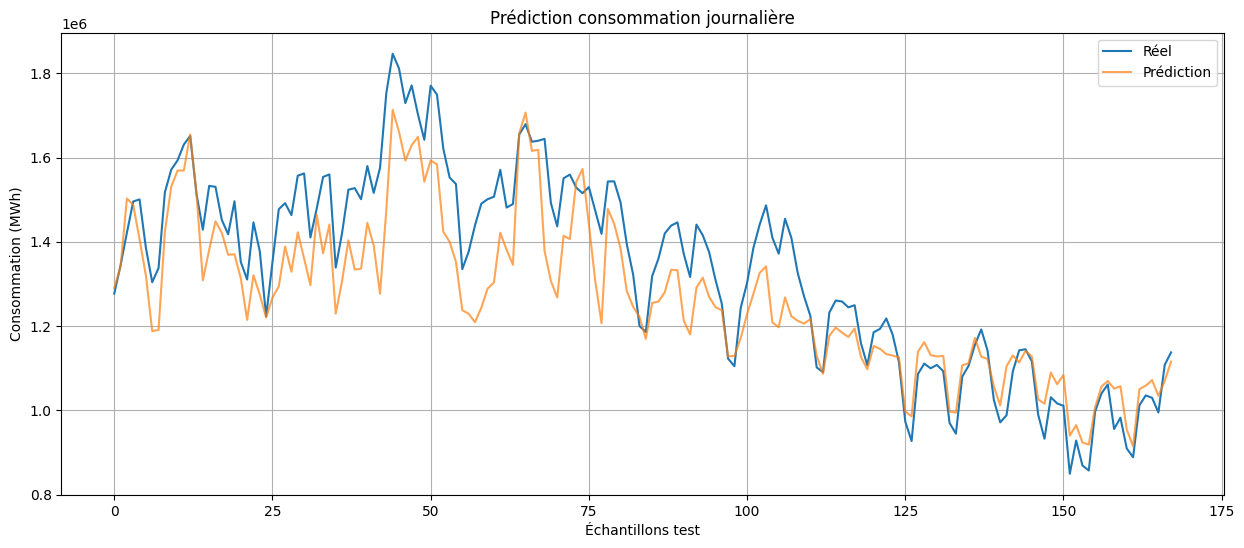

In [16]:

plt.figure(figsize=(15,6))
plt.plot(y_test.values, label='Réel')
plt.plot(y_pred, label='Prédiction', alpha=0.7)
plt.title('Prédiction consommation journalière')
plt.xlabel('Échantillons test')
plt.ylabel('Consommation (MWh)')
plt.legend()
plt.grid(True)
plt.show()


In [17]:

from sklearn.model_selection import GridSearchCV

# Définir la grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Lancer la recherche par validation croisée
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='r2', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
print("Best parameters found: ", grid_search.best_params_)

# Prédiction avec le meilleur modèle
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(X_test)

# Évaluation des performances
r2_grid = r2_score(y_test, y_pred_grid)
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
mape_grid = mean_absolute_percentage_error(y_test, y_pred_grid)


print(f"Optimisé - R²: {r2_grid:.3f}, RMSE: {rmse_grid:.2f} MWh, MAPE: {mape_grid:.2%}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Optimisé - R²: 0.798, RMSE: 104515.43 MWh, MAPE: 6.03%


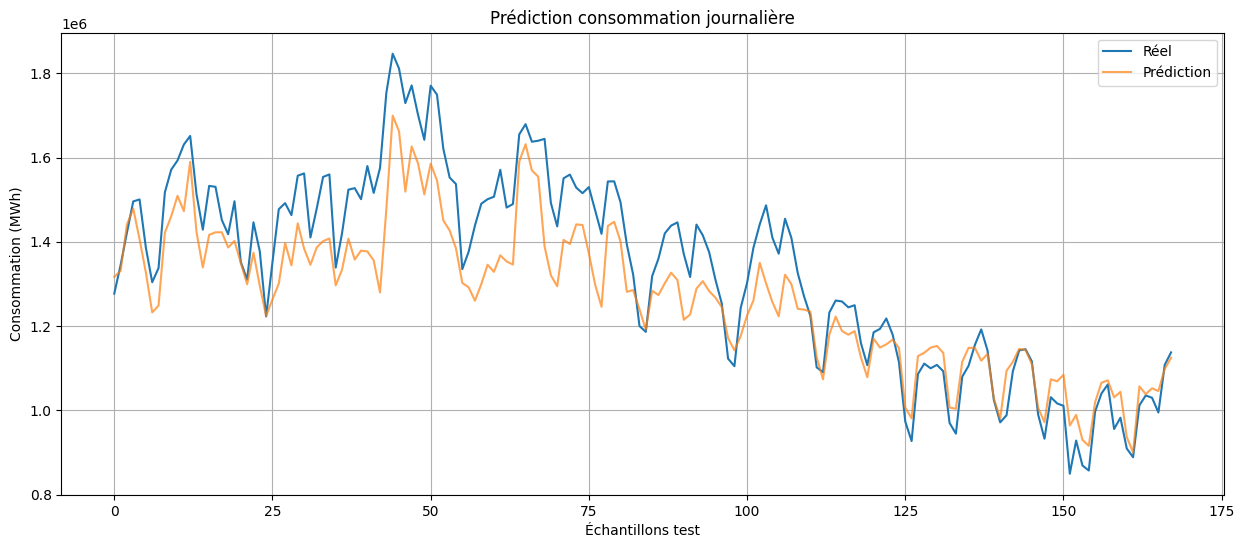

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.plot(y_test.values, label='Réel')
plt.plot(y_pred_grid, label='Prédiction', alpha=0.7)
plt.title('Prédiction consommation journalière')
plt.xlabel('Échantillons test')
plt.ylabel('Consommation (MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
best_model.get_booster().save_model('model_xgboost_journalier_optimise.json')


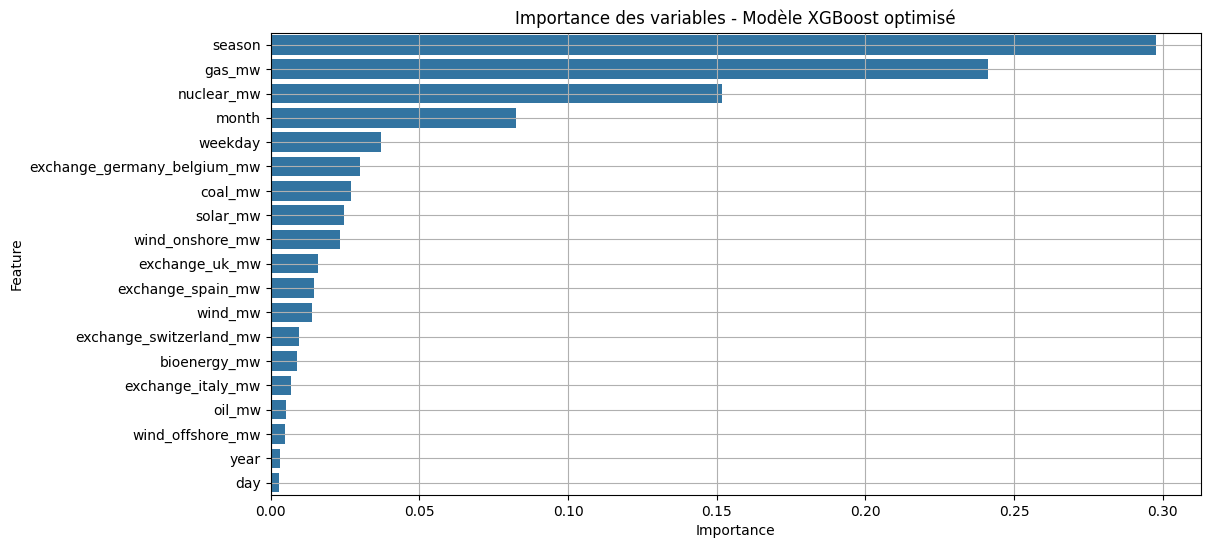

In [20]:

# Visualisation des feature importances (gain)
import seaborn as sns

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importance des variables - Modèle XGBoost optimisé')
plt.grid(True)
plt.show()
